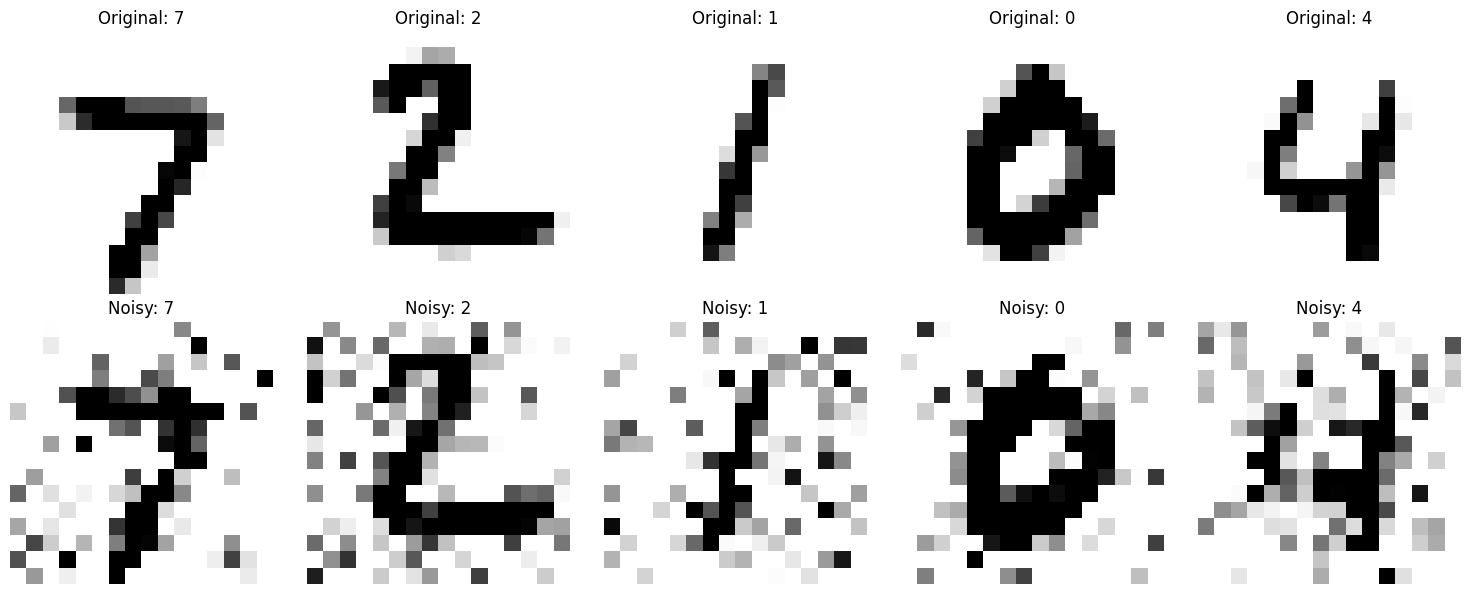

In [21]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

def add_noise(image, noise_factor=0.5):
    """Adds Gaussian noise to the image with a smoother distribution."""
    # Generate Gaussian noise with mean 0 and standard deviation 1
    noise = torch.randn(image.size())
    
    # Scale the noise by the noise factor
    noise = noise * noise_factor
    
    # Normalize the noise to be centered around 0.5 (mid-gray) with reduced intensity
    noisy_image = image + noise
    
    # Clip values to ensure the image stays in the range [0, 1]
    return torch.clamp(noisy_image, 0., 1.)

class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, noise_factor=0.5):
        self.mnist_dataset = mnist_dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        noisy_image = add_noise(image, self.noise_factor)
        return noisy_image, label

def visualize_noisy_mnist(noise_factor=0.5, num_samples=5):
    """Visualizes a few samples of noisy MNIST images."""
    # Load original MNIST dataset
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert the image to black digits on white background
    ])
    mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Create NoisyMNISTDataset
    noisy_mnist_dataset = NoisyMNISTDataset(mnist_test, noise_factor)
    
    # Create a figure
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(num_samples):
        # Get a sample from the original MNIST dataset
        original_image, label = mnist_test[i]
        
        # Get the corresponding noisy image
        noisy_image, _ = noisy_mnist_dataset[i]
        
        # Display original image
        axes[0, i].imshow(original_image.squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(f"Original: {label}")
        axes[0, i].axis('off')
        
        # Display noisy image
        axes[1, i].imshow(noisy_image.squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[1, i].set_title(f"Noisy: {label}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_noisy_mnist(noise_factor=0.7)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
from tqdm import tqdm
import os
import zipfile
from PIL import Image

# Function to add noise
def add_noise(image, noise_factor=0.5):
    noise = noise_factor * torch.randn(image.size())
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)

# NoisyMNISTDataset class
class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, noise_factor=0.5):
        self.mnist_dataset = mnist_dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        noisy_image = add_noise(image, self.noise_factor)
        return noisy_image, label

# Load experimental data
def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

# Function to invert the MNIST images (black digits on white background)
def invert_image(image):
    return 1 - image

# Load MNIST datasets
def load_mnist_datasets():
    # Replace the lambda function with a regular function
    mnist_transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(invert_image)  # Use invert_image function instead of lambda
    ])
    
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
    
    noisy_mnist_train = NoisyMNISTDataset(mnist_train, noise_factor=0.7)
    noisy_mnist_test = NoisyMNISTDataset(mnist_test, noise_factor=0.7)
    
    return mnist_train, mnist_test, noisy_mnist_train, noisy_mnist_test

# Create the ResNet50 model
def create_resnet50_model():
    model = models.resnet50(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

# Training function
def train_model(model, train_dataloaders, val_dataloaders, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        
        for phase, dataloader in train_dataloaders.items():
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm(dataloader, desc=f"Training on {phase}"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
            epoch_loss = running_loss / total
            epoch_acc = correct / total
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for phase, dataloader in val_dataloaders.items():
                for inputs, labels in tqdm(dataloader, desc=f"Validating on {phase}"):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)
                    
                val_epoch_loss = val_loss / val_total
                val_epoch_acc = val_correct / val_total
                print(f"Validation ({phase}) Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")
        
        scheduler.step()
    # Save the model after training
    torch.save(model.state_dict(), 'resnet50_mnist_experiment.pth')
    print("Model saved as resnet50_mnist_experiment.pth")
    print("Training completed.")

def main():
    # Load MNIST datasets
    mnist_train, mnist_test, noisy_mnist_train, noisy_mnist_test = load_mnist_datasets()

    # Load experimental data
    exp_train_images, exp_train_labels, exp_test_images, exp_test_labels, participant_data = load_all_experimental_data('test_digits')
    
    # Create DataLoaders for training and validation
    train_dataloaders = {
        "mnist_inverted": DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=0),
        "mnist_noisy": DataLoader(noisy_mnist_train, batch_size=64, shuffle=True, num_workers=0),
        "experimental": DataLoader(TensorDataset(exp_train_images, exp_train_labels), batch_size=64, shuffle=True, num_workers=0)
    }
    
    val_dataloaders = {
        "mnist_inverted": DataLoader(mnist_test, batch_size=64, shuffle=False, num_workers=0),
        "mnist_noisy": DataLoader(noisy_mnist_test, batch_size=64, shuffle=False, num_workers=0),
        "experimental": DataLoader(TensorDataset(exp_test_images, exp_test_labels), batch_size=64, shuffle=False, num_workers=0)
    }
    
    # Create the model
    model = create_resnet50_model()

    # Train the model
    train_model(model, train_dataloaders, val_dataloaders, num_epochs=100)

if __name__ == "__main__":
    main()

Epoch 1/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:47<00:00, 19.82it/s]


mnist_inverted Loss: 0.2921 Acc: 0.9141


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.70it/s]


mnist_noisy Loss: 0.3338 Acc: 0.8972


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.68it/s]


experimental Loss: 2.4953 Acc: 0.1041


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.06it/s]


Validation (mnist_inverted) Loss: 14.4562 Acc: 0.0715


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.48it/s]


Validation (mnist_noisy) Loss: 8.5438 Acc: 0.0712


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 100.44it/s]


Validation (experimental) Loss: 8.5041 Acc: 0.0719
Epoch 2/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.48it/s]


mnist_inverted Loss: 0.2297 Acc: 0.9336


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.05it/s]


mnist_noisy Loss: 0.2527 Acc: 0.9212


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.40it/s]


experimental Loss: 2.4384 Acc: 0.1088


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.82it/s]


Validation (mnist_inverted) Loss: 7.7902 Acc: 0.1377


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.88it/s]


Validation (mnist_noisy) Loss: 5.0446 Acc: 0.1340


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 141.03it/s]


Validation (experimental) Loss: 5.0253 Acc: 0.1344
Epoch 3/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.93it/s]


mnist_inverted Loss: 0.2029 Acc: 0.9398


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.13it/s]


mnist_noisy Loss: 0.2518 Acc: 0.9224


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.44it/s]


experimental Loss: 2.4236 Acc: 0.1075


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.59it/s]


Validation (mnist_inverted) Loss: 2.2807 Acc: 0.1108


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.53it/s]


Validation (mnist_noisy) Loss: 2.2833 Acc: 0.1520


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 166.35it/s]


Validation (experimental) Loss: 2.2830 Acc: 0.1526
Epoch 4/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.94it/s]


mnist_inverted Loss: 0.2186 Acc: 0.9353


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.03it/s]


mnist_noisy Loss: 0.2439 Acc: 0.9245


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.60it/s]


experimental Loss: 2.4102 Acc: 0.1114


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.33it/s]


Validation (mnist_inverted) Loss: 3.3909 Acc: 0.0599


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.03it/s]


Validation (mnist_noisy) Loss: 2.8460 Acc: 0.0990


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 84.76it/s]


Validation (experimental) Loss: 2.8416 Acc: 0.1003
Epoch 5/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.76it/s]


mnist_inverted Loss: 0.1709 Acc: 0.9486


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.91it/s]


mnist_noisy Loss: 0.2038 Acc: 0.9349


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.67it/s]


experimental Loss: 2.4032 Acc: 0.1111


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.31it/s]


Validation (mnist_inverted) Loss: 2.2744 Acc: 0.1562


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.05it/s]


Validation (mnist_noisy) Loss: 2.2687 Acc: 0.1416


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 87.10it/s]


Validation (experimental) Loss: 2.2685 Acc: 0.1418
Epoch 6/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.78it/s]


mnist_inverted Loss: 0.1861 Acc: 0.9427


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.75it/s]


mnist_noisy Loss: 0.2389 Acc: 0.9254


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.65it/s]


experimental Loss: 2.4024 Acc: 0.1151


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.52it/s]


Validation (mnist_inverted) Loss: 2.0332 Acc: 0.2257


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.97it/s]


Validation (mnist_noisy) Loss: 2.1358 Acc: 0.2061


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 141.63it/s]


Validation (experimental) Loss: 2.1361 Acc: 0.2063
Epoch 7/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:48<00:00, 19.21it/s]


mnist_inverted Loss: 0.1257 Acc: 0.9677


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.91it/s]


mnist_noisy Loss: 0.1751 Acc: 0.9444


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.57it/s]


experimental Loss: 2.3909 Acc: 0.1143


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.93it/s]


Validation (mnist_inverted) Loss: 2.1000 Acc: 0.2734


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.06it/s]


Validation (mnist_noisy) Loss: 2.1430 Acc: 0.2617


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 81.98it/s]


Validation (experimental) Loss: 2.1437 Acc: 0.2623
Epoch 8/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.63it/s]


mnist_inverted Loss: 0.1232 Acc: 0.9705


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.86it/s]


mnist_noisy Loss: 0.1648 Acc: 0.9475


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.41it/s]


experimental Loss: 2.3885 Acc: 0.1140


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.30it/s]


Validation (mnist_inverted) Loss: 3.2394 Acc: 0.2778


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.61it/s]


Validation (mnist_noisy) Loss: 3.0662 Acc: 0.1530


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 95.57it/s]


Validation (experimental) Loss: 3.0597 Acc: 0.1543
Epoch 9/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.58it/s]


mnist_inverted Loss: 0.1211 Acc: 0.9702


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.90it/s]


mnist_noisy Loss: 0.1581 Acc: 0.9500


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.67it/s]


experimental Loss: 2.3765 Acc: 0.1205


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.06it/s]


Validation (mnist_inverted) Loss: 1.9785 Acc: 0.2894


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.23it/s]


Validation (mnist_noisy) Loss: 2.1224 Acc: 0.2031


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 98.66it/s]


Validation (experimental) Loss: 2.1216 Acc: 0.2045
Epoch 10/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.54it/s]


mnist_inverted Loss: 0.0946 Acc: 0.9799


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.13it/s]


mnist_noisy Loss: 0.1464 Acc: 0.9534


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.31it/s]


experimental Loss: 2.3710 Acc: 0.1210


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.89it/s]


Validation (mnist_inverted) Loss: 1.9177 Acc: 0.3858


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.18it/s]


Validation (mnist_noisy) Loss: 2.0728 Acc: 0.2706


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 85.61it/s]


Validation (experimental) Loss: 2.0720 Acc: 0.2713
Epoch 11/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.01it/s]


mnist_inverted Loss: 0.2350 Acc: 0.9757


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.19it/s]


mnist_noisy Loss: 0.1451 Acc: 0.9553


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.05it/s]


experimental Loss: 2.3598 Acc: 0.1408


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.80it/s]


Validation (mnist_inverted) Loss: 1.2378 Acc: 0.5829


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.73it/s]


Validation (mnist_noisy) Loss: 1.5683 Acc: 0.4985


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 127.78it/s]


Validation (experimental) Loss: 1.5700 Acc: 0.4980
Epoch 12/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.97it/s]


mnist_inverted Loss: 0.0521 Acc: 0.9889


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.68it/s]


mnist_noisy Loss: 0.1282 Acc: 0.9605


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.43it/s]


experimental Loss: 2.2876 Acc: 0.1485


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.28it/s]


Validation (mnist_inverted) Loss: 1.1984 Acc: 0.6364


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.89it/s]


Validation (mnist_noisy) Loss: 1.5069 Acc: 0.5215


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 77.25it/s]


Validation (experimental) Loss: 1.5088 Acc: 0.5209
Epoch 13/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.50it/s]


mnist_inverted Loss: 0.0347 Acc: 0.9908


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.57it/s]


mnist_noisy Loss: 0.1199 Acc: 0.9621


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 26.99it/s]


experimental Loss: 2.2680 Acc: 0.1523


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.53it/s]


Validation (mnist_inverted) Loss: 1.2846 Acc: 0.5719


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.75it/s]


Validation (mnist_noisy) Loss: 1.5706 Acc: 0.4509


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 141.55it/s]


Validation (experimental) Loss: 1.5725 Acc: 0.4506
Epoch 14/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.47it/s]


mnist_inverted Loss: 0.0283 Acc: 0.9923


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.69it/s]


mnist_noisy Loss: 0.1184 Acc: 0.9625


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.41it/s]


experimental Loss: 2.2578 Acc: 0.1583


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.97it/s]


Validation (mnist_inverted) Loss: 1.2387 Acc: 0.5788


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.22it/s]


Validation (mnist_noisy) Loss: 1.5544 Acc: 0.4364


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 102.10it/s]


Validation (experimental) Loss: 1.5564 Acc: 0.4362
Epoch 15/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.48it/s]


mnist_inverted Loss: 0.0259 Acc: 0.9926


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.63it/s]


mnist_noisy Loss: 0.1117 Acc: 0.9639


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.52it/s]


experimental Loss: 2.2470 Acc: 0.1665


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.53it/s]


Validation (mnist_inverted) Loss: 1.3119 Acc: 0.5743


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.13it/s]


Validation (mnist_noisy) Loss: 1.5459 Acc: 0.4527


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 85.45it/s]


Validation (experimental) Loss: 1.5478 Acc: 0.4525
Epoch 16/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.52it/s]


mnist_inverted Loss: 0.0231 Acc: 0.9933


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.68it/s]


mnist_noisy Loss: 0.1091 Acc: 0.9643


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.51it/s]


experimental Loss: 2.2417 Acc: 0.1687


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.35it/s]


Validation (mnist_inverted) Loss: 1.3130 Acc: 0.5840


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.85it/s]


Validation (mnist_noisy) Loss: 1.5326 Acc: 0.4838


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 108.66it/s]


Validation (experimental) Loss: 1.5345 Acc: 0.4837
Epoch 17/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.53it/s]


mnist_inverted Loss: 0.0213 Acc: 0.9939


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.03it/s]


mnist_noisy Loss: 0.1051 Acc: 0.9658


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.49it/s]


experimental Loss: 2.2339 Acc: 0.1744


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.49it/s]


Validation (mnist_inverted) Loss: 1.3622 Acc: 0.5566


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.43it/s]


Validation (mnist_noisy) Loss: 1.5986 Acc: 0.4324


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 104.88it/s]


Validation (experimental) Loss: 1.6003 Acc: 0.4325
Epoch 18/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.14it/s]


mnist_inverted Loss: 0.0192 Acc: 0.9946


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.32it/s]


mnist_noisy Loss: 0.1041 Acc: 0.9668


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.15it/s]


experimental Loss: 2.2254 Acc: 0.1781


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.63it/s]


Validation (mnist_inverted) Loss: 1.5990 Acc: 0.5100


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.26it/s]


Validation (mnist_noisy) Loss: 1.6783 Acc: 0.4462


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 106.71it/s]


Validation (experimental) Loss: 1.6788 Acc: 0.4463
Epoch 19/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.15it/s]


mnist_inverted Loss: 0.0186 Acc: 0.9946


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


mnist_noisy Loss: 0.0999 Acc: 0.9678


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.04it/s]


experimental Loss: 2.2194 Acc: 0.1824


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 51.52it/s]


Validation (mnist_inverted) Loss: 1.3848 Acc: 0.5323


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.74it/s]


Validation (mnist_noisy) Loss: 1.5302 Acc: 0.4668


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 83.33it/s]


Validation (experimental) Loss: 1.5311 Acc: 0.4666
Epoch 20/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.37it/s]


mnist_inverted Loss: 0.0170 Acc: 0.9951


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


mnist_noisy Loss: 0.0988 Acc: 0.9678


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.41it/s]


experimental Loss: 2.2121 Acc: 0.1850


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.26it/s]


Validation (mnist_inverted) Loss: 1.4157 Acc: 0.5313


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.70it/s]


Validation (mnist_noisy) Loss: 1.6139 Acc: 0.4541


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 98.92it/s]


Validation (experimental) Loss: 1.6142 Acc: 0.4543
Epoch 21/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.13it/s]


mnist_inverted Loss: 0.0193 Acc: 0.9948


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.37it/s]


mnist_noisy Loss: 0.0970 Acc: 0.9690


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.32it/s]


experimental Loss: 2.1947 Acc: 0.1965


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.15it/s]


Validation (mnist_inverted) Loss: 1.5128 Acc: 0.5148


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.77it/s]


Validation (mnist_noisy) Loss: 1.6695 Acc: 0.4424


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 96.11it/s]


Validation (experimental) Loss: 1.6694 Acc: 0.4426
Epoch 22/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.43it/s]


mnist_inverted Loss: 0.0170 Acc: 0.9951


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.34it/s]


mnist_noisy Loss: 0.0951 Acc: 0.9691


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.28it/s]


experimental Loss: 2.1931 Acc: 0.1958


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.48it/s]


Validation (mnist_inverted) Loss: 1.6490 Acc: 0.4988


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.25it/s]


Validation (mnist_noisy) Loss: 1.7637 Acc: 0.4289


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 103.06it/s]


Validation (experimental) Loss: 1.7630 Acc: 0.4291
Epoch 23/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.05it/s]


mnist_inverted Loss: 0.0160 Acc: 0.9956


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


mnist_noisy Loss: 0.0976 Acc: 0.9684


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.25it/s]


experimental Loss: 2.1898 Acc: 0.1985


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.21it/s]


Validation (mnist_inverted) Loss: 1.7347 Acc: 0.4831


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.82it/s]


Validation (mnist_noisy) Loss: 1.8253 Acc: 0.4194


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 83.89it/s]


Validation (experimental) Loss: 1.8244 Acc: 0.4198
Epoch 24/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.10it/s]


mnist_inverted Loss: 0.0157 Acc: 0.9956


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.35it/s]


mnist_noisy Loss: 0.0977 Acc: 0.9692


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.12it/s]


experimental Loss: 2.1896 Acc: 0.2000


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.01it/s]


Validation (mnist_inverted) Loss: 1.7399 Acc: 0.4986


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.86it/s]


Validation (mnist_noisy) Loss: 1.8291 Acc: 0.4226


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 96.01it/s]


Validation (experimental) Loss: 1.8280 Acc: 0.4230
Epoch 25/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.39it/s]


mnist_inverted Loss: 0.0158 Acc: 0.9957


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.50it/s]


mnist_noisy Loss: 0.0961 Acc: 0.9687


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.20it/s]


experimental Loss: 2.1890 Acc: 0.2033


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.17it/s]


Validation (mnist_inverted) Loss: 2.1440 Acc: 0.4790


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.51it/s]


Validation (mnist_noisy) Loss: 2.0766 Acc: 0.4085


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 91.09it/s]


Validation (experimental) Loss: 2.0748 Acc: 0.4088
Epoch 26/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.78it/s]


mnist_inverted Loss: 0.0158 Acc: 0.9956


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.87it/s]


mnist_noisy Loss: 0.0958 Acc: 0.9682


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.50it/s]


experimental Loss: 2.1858 Acc: 0.2006


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.13it/s]


Validation (mnist_inverted) Loss: 1.6477 Acc: 0.5015


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.11it/s]


Validation (mnist_noisy) Loss: 1.7801 Acc: 0.4296


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 89.30it/s]


Validation (experimental) Loss: 1.7791 Acc: 0.4298
Epoch 27/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.82it/s]


mnist_inverted Loss: 0.0151 Acc: 0.9958


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.45it/s]


mnist_noisy Loss: 0.0981 Acc: 0.9681


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.86it/s]


experimental Loss: 2.1868 Acc: 0.1999


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.12it/s]


Validation (mnist_inverted) Loss: 1.7208 Acc: 0.4945


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.20it/s]


Validation (mnist_noisy) Loss: 1.8258 Acc: 0.4259


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 94.61it/s]


Validation (experimental) Loss: 1.8244 Acc: 0.4262
Epoch 28/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.27it/s]


mnist_inverted Loss: 0.0148 Acc: 0.9958


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.81it/s]


mnist_noisy Loss: 0.0973 Acc: 0.9677


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.06it/s]


experimental Loss: 2.1836 Acc: 0.2030


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 51.11it/s]


Validation (mnist_inverted) Loss: 1.5467 Acc: 0.5273


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.80it/s]


Validation (mnist_noisy) Loss: 1.7026 Acc: 0.4494


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 89.87it/s]


Validation (experimental) Loss: 1.7021 Acc: 0.4494
Epoch 29/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.80it/s]


mnist_inverted Loss: 0.0147 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.86it/s]


mnist_noisy Loss: 0.0927 Acc: 0.9695


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.25it/s]


experimental Loss: 2.1825 Acc: 0.2049


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.51it/s]


Validation (mnist_inverted) Loss: 1.8256 Acc: 0.4905


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.44it/s]


Validation (mnist_noisy) Loss: 1.9104 Acc: 0.4203


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.43it/s]


Validation (experimental) Loss: 1.9099 Acc: 0.4204
Epoch 30/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.15it/s]


mnist_inverted Loss: 0.0149 Acc: 0.9959


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.47it/s]


mnist_noisy Loss: 0.0952 Acc: 0.9691


Training on experimental: 100%|██████████| 485/485 [00:16<00:00, 28.89it/s]


experimental Loss: 2.1822 Acc: 0.2043


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.20it/s]


Validation (mnist_inverted) Loss: 1.9866 Acc: 0.4825


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.38it/s]


Validation (mnist_noisy) Loss: 1.9760 Acc: 0.4197


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 92.91it/s]


Validation (experimental) Loss: 1.9741 Acc: 0.4201
Epoch 31/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.77it/s]


mnist_inverted Loss: 0.0147 Acc: 0.9958


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.84it/s]


mnist_noisy Loss: 0.0952 Acc: 0.9693


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.19it/s]


experimental Loss: 2.1790 Acc: 0.2038


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 44.82it/s]


Validation (mnist_inverted) Loss: 1.7713 Acc: 0.4921


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.16it/s]


Validation (mnist_noisy) Loss: 1.8855 Acc: 0.4209


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 80.51it/s]


Validation (experimental) Loss: 1.8840 Acc: 0.4212
Epoch 32/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.75it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9962


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.86it/s]


mnist_noisy Loss: 0.0949 Acc: 0.9695


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.17it/s]


experimental Loss: 2.1795 Acc: 0.2053


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.42it/s]


Validation (mnist_inverted) Loss: 1.6808 Acc: 0.5048


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.96it/s]


Validation (mnist_noisy) Loss: 1.8112 Acc: 0.4345


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 96.19it/s]


Validation (experimental) Loss: 1.8100 Acc: 0.4348
Epoch 33/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.25it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.77it/s]


mnist_noisy Loss: 0.0928 Acc: 0.9702


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.11it/s]


experimental Loss: 2.1782 Acc: 0.2050


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.55it/s]


Validation (mnist_inverted) Loss: 1.7180 Acc: 0.5063


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.28it/s]


Validation (mnist_noisy) Loss: 1.8560 Acc: 0.4259


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 70.87it/s]


Validation (experimental) Loss: 1.8550 Acc: 0.4261
Epoch 34/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.97it/s]


mnist_inverted Loss: 0.0151 Acc: 0.9957


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.17it/s]


mnist_noisy Loss: 0.0935 Acc: 0.9688


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.31it/s]


experimental Loss: 2.1779 Acc: 0.2050


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.57it/s]


Validation (mnist_inverted) Loss: 2.0444 Acc: 0.4924


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.36it/s]


Validation (mnist_noisy) Loss: 2.0320 Acc: 0.4188


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 95.48it/s]


Validation (experimental) Loss: 2.0314 Acc: 0.4190
Epoch 35/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.12it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9962


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.22it/s]


mnist_noisy Loss: 0.0960 Acc: 0.9686


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.24it/s]


experimental Loss: 2.1766 Acc: 0.2056


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.30it/s]


Validation (mnist_inverted) Loss: 1.8250 Acc: 0.4936


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 39.60it/s]


Validation (mnist_noisy) Loss: 1.9001 Acc: 0.4269


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 68.64it/s]


Validation (experimental) Loss: 1.8987 Acc: 0.4271
Epoch 36/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.23it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9958


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.14it/s]


mnist_noisy Loss: 0.0937 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.37it/s]


experimental Loss: 2.1775 Acc: 0.2043


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.51it/s]


Validation (mnist_inverted) Loss: 1.7145 Acc: 0.4945


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.41it/s]


Validation (mnist_noisy) Loss: 1.8248 Acc: 0.4264


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 90.28it/s]


Validation (experimental) Loss: 1.8236 Acc: 0.4267
Epoch 37/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.00it/s]


mnist_inverted Loss: 0.0147 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.13it/s]


mnist_noisy Loss: 0.0954 Acc: 0.9687


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.58it/s]


experimental Loss: 2.1778 Acc: 0.2066


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.19it/s]


Validation (mnist_inverted) Loss: 1.6162 Acc: 0.5127


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.72it/s]


Validation (mnist_noisy) Loss: 1.7697 Acc: 0.4415


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 102.61it/s]


Validation (experimental) Loss: 1.7688 Acc: 0.4416
Epoch 38/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.33it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.52it/s]


mnist_noisy Loss: 0.0932 Acc: 0.9697


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.35it/s]


experimental Loss: 2.1769 Acc: 0.2053


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.94it/s]


Validation (mnist_inverted) Loss: 1.8686 Acc: 0.4906


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.61it/s]


Validation (mnist_noisy) Loss: 1.9178 Acc: 0.4228


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 98.63it/s]


Validation (experimental) Loss: 1.9166 Acc: 0.4230
Epoch 39/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.98it/s]


mnist_inverted Loss: 0.0147 Acc: 0.9959


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.51it/s]


mnist_noisy Loss: 0.0944 Acc: 0.9692


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.42it/s]


experimental Loss: 2.1775 Acc: 0.2072


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.77it/s]


Validation (mnist_inverted) Loss: 1.8463 Acc: 0.4894


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.42it/s]


Validation (mnist_noisy) Loss: 1.9340 Acc: 0.4169


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 100.79it/s]


Validation (experimental) Loss: 1.9325 Acc: 0.4173
Epoch 40/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.18it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.62it/s]


mnist_noisy Loss: 0.0931 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.07it/s]


experimental Loss: 2.1744 Acc: 0.2073


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.83it/s]


Validation (mnist_inverted) Loss: 1.8476 Acc: 0.4916


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.18it/s]


Validation (mnist_noisy) Loss: 1.9028 Acc: 0.4204


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.92it/s]


Validation (experimental) Loss: 1.9017 Acc: 0.4207
Epoch 41/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.11it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.32it/s]


mnist_noisy Loss: 0.0939 Acc: 0.9693


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.76it/s]


experimental Loss: 2.1765 Acc: 0.2069


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.23it/s]


Validation (mnist_inverted) Loss: 1.7515 Acc: 0.4930


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.99it/s]


Validation (mnist_noisy) Loss: 1.8558 Acc: 0.4190


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 104.96it/s]


Validation (experimental) Loss: 1.8545 Acc: 0.4194
Epoch 42/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.72it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.01it/s]


mnist_noisy Loss: 0.0921 Acc: 0.9698


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.72it/s]


experimental Loss: 2.1771 Acc: 0.2052


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.48it/s]


Validation (mnist_inverted) Loss: 1.8531 Acc: 0.4840


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.26it/s]


Validation (mnist_noisy) Loss: 1.9234 Acc: 0.4163


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 99.65it/s]


Validation (experimental) Loss: 1.9217 Acc: 0.4167
Epoch 43/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.10it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.78it/s]


mnist_noisy Loss: 0.0937 Acc: 0.9698


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.17it/s]


experimental Loss: 2.1764 Acc: 0.2063


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.68it/s]


Validation (mnist_inverted) Loss: 1.7225 Acc: 0.4903


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.51it/s]


Validation (mnist_noisy) Loss: 1.8566 Acc: 0.4194


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 97.61it/s]


Validation (experimental) Loss: 1.8550 Acc: 0.4198
Epoch 44/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.06it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.87it/s]


mnist_noisy Loss: 0.0931 Acc: 0.9695


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.54it/s]


experimental Loss: 2.1778 Acc: 0.2065


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.86it/s]


Validation (mnist_inverted) Loss: 2.0391 Acc: 0.4958


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 39.86it/s]


Validation (mnist_noisy) Loss: 1.9965 Acc: 0.4248


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 90.37it/s]


Validation (experimental) Loss: 1.9953 Acc: 0.4250
Epoch 45/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.41it/s]


mnist_inverted Loss: 0.0142 Acc: 0.9962


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.89it/s]


mnist_noisy Loss: 0.0923 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.68it/s]


experimental Loss: 2.1761 Acc: 0.2062


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.59it/s]


Validation (mnist_inverted) Loss: 1.6904 Acc: 0.5019


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 39.62it/s]


Validation (mnist_noisy) Loss: 1.8144 Acc: 0.4349


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 82.89it/s]


Validation (experimental) Loss: 1.8131 Acc: 0.4351
Epoch 46/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.37it/s]


mnist_inverted Loss: 0.0141 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.42it/s]


mnist_noisy Loss: 0.0938 Acc: 0.9698


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.24it/s]


experimental Loss: 2.1770 Acc: 0.2064


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.19it/s]


Validation (mnist_inverted) Loss: 1.6257 Acc: 0.5021


Validating on mnist_noisy: 100%|██████████| 157/157 [00:04<00:00, 38.93it/s]


Validation (mnist_noisy) Loss: 1.7865 Acc: 0.4294


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 86.17it/s]


Validation (experimental) Loss: 1.7853 Acc: 0.4296
Epoch 47/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.93it/s]


mnist_inverted Loss: 0.0142 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.25it/s]


mnist_noisy Loss: 0.0961 Acc: 0.9687


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.36it/s]


experimental Loss: 2.1775 Acc: 0.2058


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.26it/s]


Validation (mnist_inverted) Loss: 1.8369 Acc: 0.4912


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.98it/s]


Validation (mnist_noisy) Loss: 1.9354 Acc: 0.4189


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 91.25it/s]


Validation (experimental) Loss: 1.9340 Acc: 0.4191
Epoch 48/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.35it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.22it/s]


mnist_noisy Loss: 0.0901 Acc: 0.9697


Training on experimental: 100%|██████████| 485/485 [00:16<00:00, 28.70it/s]


experimental Loss: 2.1763 Acc: 0.2058


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.64it/s]


Validation (mnist_inverted) Loss: 1.6755 Acc: 0.4994


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.10it/s]


Validation (mnist_noisy) Loss: 1.8133 Acc: 0.4301


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 88.26it/s]


Validation (experimental) Loss: 1.8120 Acc: 0.4304
Epoch 49/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.75it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9959


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.01it/s]


mnist_noisy Loss: 0.0919 Acc: 0.9699


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 26.97it/s]


experimental Loss: 2.1769 Acc: 0.2067


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.36it/s]


Validation (mnist_inverted) Loss: 1.7263 Acc: 0.4944


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.31it/s]


Validation (mnist_noisy) Loss: 1.8682 Acc: 0.4213


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 99.72it/s]


Validation (experimental) Loss: 1.8666 Acc: 0.4215
Epoch 50/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.03it/s]


mnist_inverted Loss: 0.0143 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


mnist_noisy Loss: 0.0937 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.19it/s]


experimental Loss: 2.1776 Acc: 0.2062


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.54it/s]


Validation (mnist_inverted) Loss: 1.6422 Acc: 0.4978


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.49it/s]


Validation (mnist_noisy) Loss: 1.7918 Acc: 0.4259


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 87.19it/s]


Validation (experimental) Loss: 1.7906 Acc: 0.4262
Epoch 51/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.32it/s]


mnist_inverted Loss: 0.0143 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.39it/s]


mnist_noisy Loss: 0.0923 Acc: 0.9689


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.80it/s]


experimental Loss: 2.1772 Acc: 0.2051


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.87it/s]


Validation (mnist_inverted) Loss: 1.9255 Acc: 0.4843


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.31it/s]


Validation (mnist_noisy) Loss: 1.9501 Acc: 0.4208


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 99.29it/s]


Validation (experimental) Loss: 1.9493 Acc: 0.4210
Epoch 52/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.28it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.25it/s]


mnist_noisy Loss: 0.0962 Acc: 0.9689


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.42it/s]


experimental Loss: 2.1779 Acc: 0.2061


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.64it/s]


Validation (mnist_inverted) Loss: 1.9889 Acc: 0.4804


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.74it/s]


Validation (mnist_noisy) Loss: 1.9963 Acc: 0.4122


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 82.81it/s]


Validation (experimental) Loss: 1.9952 Acc: 0.4125
Epoch 53/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.29it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.29it/s]


mnist_noisy Loss: 0.0932 Acc: 0.9689


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.60it/s]


experimental Loss: 2.1759 Acc: 0.2066


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.17it/s]


Validation (mnist_inverted) Loss: 1.8535 Acc: 0.4902


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.25it/s]


Validation (mnist_noisy) Loss: 1.9000 Acc: 0.4259


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 95.83it/s]


Validation (experimental) Loss: 1.8988 Acc: 0.4261
Epoch 54/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.44it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.15it/s]


mnist_noisy Loss: 0.0953 Acc: 0.9689


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.13it/s]


experimental Loss: 2.1770 Acc: 0.2053


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.63it/s]


Validation (mnist_inverted) Loss: 1.7147 Acc: 0.4938


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.77it/s]


Validation (mnist_noisy) Loss: 1.8570 Acc: 0.4213


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 104.29it/s]


Validation (experimental) Loss: 1.8554 Acc: 0.4216
Epoch 55/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.15it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9959


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.19it/s]


mnist_noisy Loss: 0.0916 Acc: 0.9702


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.86it/s]


experimental Loss: 2.1766 Acc: 0.2058


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.75it/s]


Validation (mnist_inverted) Loss: 1.6003 Acc: 0.5083


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.54it/s]


Validation (mnist_noisy) Loss: 1.7800 Acc: 0.4315


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 90.19it/s]


Validation (experimental) Loss: 1.7789 Acc: 0.4318
Epoch 56/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.01it/s]


mnist_inverted Loss: 0.0140 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.31it/s]


mnist_noisy Loss: 0.0940 Acc: 0.9694


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.48it/s]


experimental Loss: 2.1771 Acc: 0.2052


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.75it/s]


Validation (mnist_inverted) Loss: 1.7853 Acc: 0.4893


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.18it/s]


Validation (mnist_noisy) Loss: 1.8550 Acc: 0.4246


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 92.73it/s]


Validation (experimental) Loss: 1.8537 Acc: 0.4249
Epoch 57/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.97it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9959


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.83it/s]


mnist_noisy Loss: 0.0943 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:16<00:00, 28.92it/s]


experimental Loss: 2.1752 Acc: 0.2053


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.21it/s]


Validation (mnist_inverted) Loss: 1.8029 Acc: 0.4933


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.21it/s]


Validation (mnist_noisy) Loss: 1.8986 Acc: 0.4240


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 102.00it/s]


Validation (experimental) Loss: 1.8971 Acc: 0.4242
Epoch 58/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.80it/s]


mnist_inverted Loss: 0.0151 Acc: 0.9958


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.88it/s]


mnist_noisy Loss: 0.0937 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.31it/s]


experimental Loss: 2.1758 Acc: 0.2080


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.26it/s]


Validation (mnist_inverted) Loss: 1.8422 Acc: 0.4873


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.79it/s]


Validation (mnist_noisy) Loss: 1.9186 Acc: 0.4155


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 99.31it/s]


Validation (experimental) Loss: 1.9170 Acc: 0.4159
Epoch 59/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.88it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.83it/s]


mnist_noisy Loss: 0.0926 Acc: 0.9698


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.93it/s]


experimental Loss: 2.1770 Acc: 0.2051


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.20it/s]


Validation (mnist_inverted) Loss: 1.8127 Acc: 0.4841


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.10it/s]


Validation (mnist_noisy) Loss: 1.8870 Acc: 0.4173


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 90.37it/s]


Validation (experimental) Loss: 1.8855 Acc: 0.4176
Epoch 60/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.00it/s]


mnist_inverted Loss: 0.0151 Acc: 0.9957


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.92it/s]


mnist_noisy Loss: 0.0924 Acc: 0.9690


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.38it/s]


experimental Loss: 2.1756 Acc: 0.2057


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 51.08it/s]


Validation (mnist_inverted) Loss: 1.6332 Acc: 0.5009


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.66it/s]


Validation (mnist_noisy) Loss: 1.7934 Acc: 0.4290


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 85.12it/s]


Validation (experimental) Loss: 1.7922 Acc: 0.4292
Epoch 61/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.49it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.51it/s]


mnist_noisy Loss: 0.0943 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.85it/s]


experimental Loss: 2.1767 Acc: 0.2053


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.27it/s]


Validation (mnist_inverted) Loss: 1.8773 Acc: 0.4842


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.61it/s]


Validation (mnist_noisy) Loss: 1.9329 Acc: 0.4172


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 103.02it/s]


Validation (experimental) Loss: 1.9317 Acc: 0.4175
Epoch 62/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.74it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9962


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.89it/s]


mnist_noisy Loss: 0.0928 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.18it/s]


experimental Loss: 2.1763 Acc: 0.2072


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.41it/s]


Validation (mnist_inverted) Loss: 1.6724 Acc: 0.4975


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.82it/s]


Validation (mnist_noisy) Loss: 1.7925 Acc: 0.4291


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 96.17it/s]


Validation (experimental) Loss: 1.7914 Acc: 0.4294
Epoch 63/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.04it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.83it/s]


mnist_noisy Loss: 0.0911 Acc: 0.9705


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.29it/s]


experimental Loss: 2.1764 Acc: 0.2058


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.76it/s]


Validation (mnist_inverted) Loss: 1.7616 Acc: 0.4863


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.67it/s]


Validation (mnist_noisy) Loss: 1.9141 Acc: 0.4121


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 104.24it/s]


Validation (experimental) Loss: 1.9123 Acc: 0.4125
Epoch 64/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.70it/s]


mnist_inverted Loss: 0.0148 Acc: 0.9958


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.29it/s]


mnist_noisy Loss: 0.0941 Acc: 0.9688


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.84it/s]


experimental Loss: 2.1758 Acc: 0.2076


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.76it/s]


Validation (mnist_inverted) Loss: 1.7968 Acc: 0.4841


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.91it/s]


Validation (mnist_noisy) Loss: 1.8873 Acc: 0.4179


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 95.23it/s]


Validation (experimental) Loss: 1.8857 Acc: 0.4183
Epoch 65/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.77it/s]


mnist_inverted Loss: 0.0142 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.92it/s]


mnist_noisy Loss: 0.0946 Acc: 0.9689


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.48it/s]


experimental Loss: 2.1773 Acc: 0.2053


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 51.19it/s]


Validation (mnist_inverted) Loss: 1.7690 Acc: 0.4863


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.39it/s]


Validation (mnist_noisy) Loss: 1.8832 Acc: 0.4178


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 106.27it/s]


Validation (experimental) Loss: 1.8816 Acc: 0.4181
Epoch 66/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.35it/s]


mnist_inverted Loss: 0.0142 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.46it/s]


mnist_noisy Loss: 0.0939 Acc: 0.9689


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.80it/s]


experimental Loss: 2.1775 Acc: 0.2040


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.97it/s]


Validation (mnist_inverted) Loss: 1.8559 Acc: 0.4924


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.00it/s]


Validation (mnist_noisy) Loss: 1.8997 Acc: 0.4273


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 93.87it/s]


Validation (experimental) Loss: 1.8985 Acc: 0.4274
Epoch 67/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.32it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9958


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.64it/s]


mnist_noisy Loss: 0.0925 Acc: 0.9693


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.16it/s]


experimental Loss: 2.1768 Acc: 0.2064


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.25it/s]


Validation (mnist_inverted) Loss: 1.8200 Acc: 0.4810


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.45it/s]


Validation (mnist_noisy) Loss: 1.9129 Acc: 0.4138


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 100.94it/s]


Validation (experimental) Loss: 1.9113 Acc: 0.4141
Epoch 68/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.07it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.30it/s]


mnist_noisy Loss: 0.0938 Acc: 0.9695


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.10it/s]


experimental Loss: 2.1765 Acc: 0.2067


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.89it/s]


Validation (mnist_inverted) Loss: 1.6840 Acc: 0.4982


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.30it/s]


Validation (mnist_noisy) Loss: 1.8189 Acc: 0.4301


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 67.55it/s]


Validation (experimental) Loss: 1.8176 Acc: 0.4304
Epoch 69/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.35it/s]


mnist_inverted Loss: 0.0147 Acc: 0.9959


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.61it/s]


mnist_noisy Loss: 0.0924 Acc: 0.9688


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.94it/s]


experimental Loss: 2.1780 Acc: 0.2054


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.38it/s]


Validation (mnist_inverted) Loss: 1.6150 Acc: 0.5046


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.25it/s]


Validation (mnist_noisy) Loss: 1.7929 Acc: 0.4269


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 102.64it/s]


Validation (experimental) Loss: 1.7916 Acc: 0.4272
Epoch 70/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.25it/s]


mnist_inverted Loss: 0.0140 Acc: 0.9963


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.45it/s]


mnist_noisy Loss: 0.0929 Acc: 0.9693


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.23it/s]


experimental Loss: 2.1772 Acc: 0.2044


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.66it/s]


Validation (mnist_inverted) Loss: 1.6864 Acc: 0.4915


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.67it/s]


Validation (mnist_noisy) Loss: 1.8355 Acc: 0.4184


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 90.64it/s]


Validation (experimental) Loss: 1.8340 Acc: 0.4188
Epoch 71/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.21it/s]


mnist_inverted Loss: 0.0148 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.50it/s]


mnist_noisy Loss: 0.0966 Acc: 0.9689


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.90it/s]


experimental Loss: 2.1755 Acc: 0.2072


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.11it/s]


Validation (mnist_inverted) Loss: 1.8192 Acc: 0.4821


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.16it/s]


Validation (mnist_noisy) Loss: 1.9100 Acc: 0.4163


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.75it/s]


Validation (experimental) Loss: 1.9083 Acc: 0.4166
Epoch 72/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.22it/s]


mnist_inverted Loss: 0.0143 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.41it/s]


mnist_noisy Loss: 0.0925 Acc: 0.9702


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.81it/s]


experimental Loss: 2.1762 Acc: 0.2075


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.87it/s]


Validation (mnist_inverted) Loss: 1.7132 Acc: 0.4951


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.87it/s]


Validation (mnist_noisy) Loss: 1.8537 Acc: 0.4234


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 104.90it/s]


Validation (experimental) Loss: 1.8521 Acc: 0.4237
Epoch 73/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.41it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9963


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.18it/s]


mnist_noisy Loss: 0.0942 Acc: 0.9690


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.05it/s]


experimental Loss: 2.1770 Acc: 0.2059


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.97it/s]


Validation (mnist_inverted) Loss: 1.8018 Acc: 0.4895


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.76it/s]


Validation (mnist_noisy) Loss: 1.8949 Acc: 0.4177


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 84.97it/s]


Validation (experimental) Loss: 1.8935 Acc: 0.4180
Epoch 74/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.72it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.15it/s]


mnist_noisy Loss: 0.0920 Acc: 0.9702


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.79it/s]


experimental Loss: 2.1767 Acc: 0.2068


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.32it/s]


Validation (mnist_inverted) Loss: 1.7276 Acc: 0.4943


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.82it/s]


Validation (mnist_noisy) Loss: 1.8672 Acc: 0.4197


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 98.31it/s]


Validation (experimental) Loss: 1.8656 Acc: 0.4200
Epoch 75/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.74it/s]


mnist_inverted Loss: 0.0143 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.50it/s]


mnist_noisy Loss: 0.0945 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.70it/s]


experimental Loss: 2.1760 Acc: 0.2067


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.89it/s]


Validation (mnist_inverted) Loss: 1.7124 Acc: 0.4938


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.79it/s]


Validation (mnist_noisy) Loss: 1.8307 Acc: 0.4259


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 78.45it/s]


Validation (experimental) Loss: 1.8295 Acc: 0.4260
Epoch 76/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.73it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.78it/s]


mnist_noisy Loss: 0.0910 Acc: 0.9701


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.25it/s]


experimental Loss: 2.1763 Acc: 0.2071


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.01it/s]


Validation (mnist_inverted) Loss: 1.7309 Acc: 0.4869


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.67it/s]


Validation (mnist_noisy) Loss: 1.8785 Acc: 0.4149


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 99.38it/s]


Validation (experimental) Loss: 1.8768 Acc: 0.4152
Epoch 77/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.77it/s]


mnist_inverted Loss: 0.0148 Acc: 0.9958


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.76it/s]


mnist_noisy Loss: 0.0919 Acc: 0.9702


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.16it/s]


experimental Loss: 2.1767 Acc: 0.2062


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.34it/s]


Validation (mnist_inverted) Loss: 1.6951 Acc: 0.4979


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.55it/s]


Validation (mnist_noisy) Loss: 1.8344 Acc: 0.4287


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 102.78it/s]


Validation (experimental) Loss: 1.8329 Acc: 0.4289
Epoch 78/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.07it/s]


mnist_inverted Loss: 0.0144 Acc: 0.9958


Training on mnist_noisy: 100%|██████████| 938/938 [00:44<00:00, 20.89it/s]


mnist_noisy Loss: 0.0939 Acc: 0.9686


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.13it/s]


experimental Loss: 2.1754 Acc: 0.2074


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.66it/s]


Validation (mnist_inverted) Loss: 1.7602 Acc: 0.4900


Validating on mnist_noisy: 100%|██████████| 157/157 [00:04<00:00, 38.77it/s]


Validation (mnist_noisy) Loss: 1.8717 Acc: 0.4200


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 97.58it/s]


Validation (experimental) Loss: 1.8702 Acc: 0.4204
Epoch 79/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.86it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.82it/s]


mnist_noisy Loss: 0.0916 Acc: 0.9700


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.24it/s]


experimental Loss: 2.1768 Acc: 0.2057


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.12it/s]


Validation (mnist_inverted) Loss: 1.6280 Acc: 0.4991


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 39.72it/s]


Validation (mnist_noisy) Loss: 1.7809 Acc: 0.4271


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 99.17it/s]


Validation (experimental) Loss: 1.7797 Acc: 0.4274
Epoch 80/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.81it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.11it/s]


mnist_noisy Loss: 0.0942 Acc: 0.9691


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.75it/s]


experimental Loss: 2.1760 Acc: 0.2051


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.63it/s]


Validation (mnist_inverted) Loss: 1.7295 Acc: 0.4932


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.92it/s]


Validation (mnist_noisy) Loss: 1.8469 Acc: 0.4223


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 100.05it/s]


Validation (experimental) Loss: 1.8456 Acc: 0.4226
Epoch 81/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.71it/s]


mnist_inverted Loss: 0.0143 Acc: 0.9962


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.19it/s]


mnist_noisy Loss: 0.0959 Acc: 0.9687


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.38it/s]


experimental Loss: 2.1772 Acc: 0.2042


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.69it/s]


Validation (mnist_inverted) Loss: 1.7741 Acc: 0.4902


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.03it/s]


Validation (mnist_noisy) Loss: 1.8772 Acc: 0.4173


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 93.16it/s]


Validation (experimental) Loss: 1.8758 Acc: 0.4178
Epoch 82/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.11it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.28it/s]


mnist_noisy Loss: 0.0959 Acc: 0.9687


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.61it/s]


experimental Loss: 2.1778 Acc: 0.2071


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.37it/s]


Validation (mnist_inverted) Loss: 1.7372 Acc: 0.4896


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.57it/s]


Validation (mnist_noisy) Loss: 1.8818 Acc: 0.4168


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 99.06it/s]


Validation (experimental) Loss: 1.8801 Acc: 0.4171
Epoch 83/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.36it/s]


mnist_inverted Loss: 0.0142 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.19it/s]


mnist_noisy Loss: 0.0924 Acc: 0.9698


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.62it/s]


experimental Loss: 2.1769 Acc: 0.2058


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.65it/s]


Validation (mnist_inverted) Loss: 1.8481 Acc: 0.4883


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.11it/s]


Validation (mnist_noisy) Loss: 1.9121 Acc: 0.4183


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 60.72it/s]


Validation (experimental) Loss: 1.9106 Acc: 0.4187
Epoch 84/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.94it/s]


mnist_inverted Loss: 0.0140 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.32it/s]


mnist_noisy Loss: 0.0918 Acc: 0.9706


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.96it/s]


experimental Loss: 2.1774 Acc: 0.2062


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.32it/s]


Validation (mnist_inverted) Loss: 1.7624 Acc: 0.4918


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.13it/s]


Validation (mnist_noisy) Loss: 1.8512 Acc: 0.4268


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 98.74it/s]


Validation (experimental) Loss: 1.8501 Acc: 0.4269
Epoch 85/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.17it/s]


mnist_inverted Loss: 0.0143 Acc: 0.9962


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.56it/s]


mnist_noisy Loss: 0.0936 Acc: 0.9693


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.21it/s]


experimental Loss: 2.1777 Acc: 0.2061


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.82it/s]


Validation (mnist_inverted) Loss: 1.8650 Acc: 0.4859


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.05it/s]


Validation (mnist_noisy) Loss: 1.9021 Acc: 0.4216


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 103.04it/s]


Validation (experimental) Loss: 1.9009 Acc: 0.4219
Epoch 86/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.15it/s]


mnist_inverted Loss: 0.0149 Acc: 0.9962


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.23it/s]


mnist_noisy Loss: 0.0924 Acc: 0.9695


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.34it/s]


experimental Loss: 2.1785 Acc: 0.2044


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.18it/s]


Validation (mnist_inverted) Loss: 1.8374 Acc: 0.4919


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.62it/s]


Validation (mnist_noisy) Loss: 1.9213 Acc: 0.4204


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 74.84it/s]


Validation (experimental) Loss: 1.9199 Acc: 0.4207
Epoch 87/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.16it/s]


mnist_inverted Loss: 0.0147 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.34it/s]


mnist_noisy Loss: 0.0957 Acc: 0.9686


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.35it/s]


experimental Loss: 2.1755 Acc: 0.2073


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.80it/s]


Validation (mnist_inverted) Loss: 1.9138 Acc: 0.4845


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.92it/s]


Validation (mnist_noisy) Loss: 1.9480 Acc: 0.4180


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 57.55it/s]


Validation (experimental) Loss: 1.9467 Acc: 0.4183
Epoch 88/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.32it/s]


mnist_inverted Loss: 0.0141 Acc: 0.9962


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.17it/s]


mnist_noisy Loss: 0.0934 Acc: 0.9691


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.47it/s]


experimental Loss: 2.1769 Acc: 0.2067


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.65it/s]


Validation (mnist_inverted) Loss: 1.7347 Acc: 0.4958


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.45it/s]


Validation (mnist_noisy) Loss: 1.8757 Acc: 0.4235


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 78.45it/s]


Validation (experimental) Loss: 1.8744 Acc: 0.4237
Epoch 89/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.03it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.08it/s]


mnist_noisy Loss: 0.0923 Acc: 0.9698


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.11it/s]


experimental Loss: 2.1761 Acc: 0.2068


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.86it/s]


Validation (mnist_inverted) Loss: 1.6918 Acc: 0.4964


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.90it/s]


Validation (mnist_noisy) Loss: 1.8410 Acc: 0.4229


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 95.44it/s]


Validation (experimental) Loss: 1.8395 Acc: 0.4232
Epoch 90/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.92it/s]


mnist_inverted Loss: 0.0142 Acc: 0.9962


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.40it/s]


mnist_noisy Loss: 0.0935 Acc: 0.9695


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.29it/s]


experimental Loss: 2.1773 Acc: 0.2029


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.27it/s]


Validation (mnist_inverted) Loss: 1.7969 Acc: 0.4910


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 39.58it/s]


Validation (mnist_noisy) Loss: 1.8733 Acc: 0.4250


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 80.67it/s]


Validation (experimental) Loss: 1.8719 Acc: 0.4253
Epoch 91/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.97it/s]


mnist_inverted Loss: 0.0149 Acc: 0.9957


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.80it/s]


mnist_noisy Loss: 0.0944 Acc: 0.9692


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.46it/s]


experimental Loss: 2.1774 Acc: 0.2059


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.62it/s]


Validation (mnist_inverted) Loss: 1.7826 Acc: 0.4805


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 39.69it/s]


Validation (mnist_noisy) Loss: 1.9024 Acc: 0.4131


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 91.41it/s]


Validation (experimental) Loss: 1.9006 Acc: 0.4135
Epoch 92/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.15it/s]


mnist_inverted Loss: 0.0145 Acc: 0.9961


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.80it/s]


mnist_noisy Loss: 0.0913 Acc: 0.9710


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.17it/s]


experimental Loss: 2.1766 Acc: 0.2065


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.68it/s]


Validation (mnist_inverted) Loss: 1.7730 Acc: 0.4970


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.66it/s]


Validation (mnist_noisy) Loss: 1.8556 Acc: 0.4291


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 98.59it/s]


Validation (experimental) Loss: 1.8545 Acc: 0.4294
Epoch 93/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.62it/s]


mnist_inverted Loss: 0.0142 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.48it/s]


mnist_noisy Loss: 0.0957 Acc: 0.9688


Training on experimental: 100%|██████████| 485/485 [00:16<00:00, 28.78it/s]


experimental Loss: 2.1765 Acc: 0.2071


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.69it/s]


Validation (mnist_inverted) Loss: 1.6977 Acc: 0.5018


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.04it/s]


Validation (mnist_noisy) Loss: 1.7979 Acc: 0.4371


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 86.34it/s]


Validation (experimental) Loss: 1.7968 Acc: 0.4372
Epoch 94/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.31it/s]


mnist_inverted Loss: 0.0143 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.37it/s]


mnist_noisy Loss: 0.0931 Acc: 0.9697


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.36it/s]


experimental Loss: 2.1765 Acc: 0.2062


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.84it/s]


Validation (mnist_inverted) Loss: 1.8136 Acc: 0.4930


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.82it/s]


Validation (mnist_noisy) Loss: 1.8976 Acc: 0.4219


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 102.74it/s]


Validation (experimental) Loss: 1.8965 Acc: 0.4221
Epoch 95/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.66it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.50it/s]


mnist_noisy Loss: 0.0937 Acc: 0.9685


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.14it/s]


experimental Loss: 2.1790 Acc: 0.2040


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 44.93it/s]


Validation (mnist_inverted) Loss: 1.7069 Acc: 0.4885


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.65it/s]


Validation (mnist_noisy) Loss: 1.8720 Acc: 0.4125


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 94.02it/s]


Validation (experimental) Loss: 1.8702 Acc: 0.4130
Epoch 96/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.68it/s]


mnist_inverted Loss: 0.0141 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 19.99it/s]


mnist_noisy Loss: 0.0929 Acc: 0.9700


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.49it/s]


experimental Loss: 2.1769 Acc: 0.2053


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.83it/s]


Validation (mnist_inverted) Loss: 1.7776 Acc: 0.4929


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.30it/s]


Validation (mnist_noisy) Loss: 1.9002 Acc: 0.4184


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 70.87it/s]


Validation (experimental) Loss: 1.8987 Acc: 0.4187
Epoch 97/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.86it/s]


mnist_inverted Loss: 0.0146 Acc: 0.9959


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.42it/s]


mnist_noisy Loss: 0.0940 Acc: 0.9691


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.10it/s]


experimental Loss: 2.1755 Acc: 0.2052


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.88it/s]


Validation (mnist_inverted) Loss: 1.7507 Acc: 0.4928


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.18it/s]


Validation (mnist_noisy) Loss: 1.8617 Acc: 0.4245


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 99.19it/s]


Validation (experimental) Loss: 1.8605 Acc: 0.4248
Epoch 98/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.07it/s]


mnist_inverted Loss: 0.0142 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


mnist_noisy Loss: 0.0902 Acc: 0.9713


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.16it/s]


experimental Loss: 2.1758 Acc: 0.2059


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 51.45it/s]


Validation (mnist_inverted) Loss: 1.6457 Acc: 0.4971


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.24it/s]


Validation (mnist_noisy) Loss: 1.8184 Acc: 0.4239


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 75.21it/s]


Validation (experimental) Loss: 1.8170 Acc: 0.4243
Epoch 99/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.43it/s]


mnist_inverted Loss: 0.0143 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.15it/s]


mnist_noisy Loss: 0.0902 Acc: 0.9702


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.68it/s]


experimental Loss: 2.1768 Acc: 0.2067


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 51.00it/s]


Validation (mnist_inverted) Loss: 1.7136 Acc: 0.5003


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.37it/s]


Validation (mnist_noisy) Loss: 1.8442 Acc: 0.4279


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.22it/s]


Validation (experimental) Loss: 1.8431 Acc: 0.4280
Epoch 100/100


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.37it/s]


mnist_inverted Loss: 0.0147 Acc: 0.9960


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.43it/s]


mnist_noisy Loss: 0.0951 Acc: 0.9692


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.64it/s]


experimental Loss: 2.1771 Acc: 0.2063


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 51.68it/s]


Validation (mnist_inverted) Loss: 1.6174 Acc: 0.5038


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.10it/s]


Validation (mnist_noisy) Loss: 1.7566 Acc: 0.4334


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 81.06it/s]


Validation (experimental) Loss: 1.7556 Acc: 0.4336
Model saved as resnet50_mnist_experiment.pth
Training completed.
